# Polatization state animations

This notebook produces a set of animations representing gravitational waves (GWs) with different polarization states: linear, circular or elliptical.

Begin with some basic imports and settings.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [8]:
import seaborn as sns
from matplotlib.patches import Circle, Wedge, Polygon
from utils.plots import EllipticalWedge
from utils.pols import *
import imageio
import warnings

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

# suppress some annoying warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

plt.rcParams["text.usetex"] = "true"

## Plotter function

In [4]:
def plot_instant(wt=0, A=0.2, ellip=1, theta=0, A0=1, Npoints=16, ax_width=None, i0=4, palette='crest'):
    
    th = linspace(0, 2*pi, Npoints, endpoint=False)
    X = A0*cos(th)
    Y = A0*sin(th)
    
    nrow, ncol = 1, 6
    ax_width = ax_width or 2*A0
    fig = figure(constrained_layout=True, figsize=(0.5*ax_width*ncol, nrow*ax_width), dpi=150)
    gs = fig.add_gridspec(2*nrow, ncol)
    
    ellip_kws = dict(ellip=ellip, theta=theta)
    wts = linspace(0, 2*pi, 100)

    # draw a the trajectory of a highlighted point
    x, y = X[i0], Y[i0]
    dxs, dys = [], []
    for wt_i in wts:
        dx, dy = dxdy_ellip([x, y], wt_i, A=A, **ellip_kws)
        dxs.append(dx)
        dys.append(dy)
    dxs = array(dxs)
    dys = array(dys)

    # initial angle for highlighted point
    th0 = arctan2(dys[0], dxs[0])

    c = sns.color_palette(palette, n_colors=Npoints)
    
    ax = fig.add_subplot(gs[:, :2])

    ax.axhline(0, 0.5, 0.6, c='gray', lw=0.5)
    ax.axvline(0, 0.5, 0.6, c='gray', lw=0.5)
    kws = dict(fontsize=14, horizontalalignment='right', verticalalignment='top')
    ax.annotate(r'$x$', xy=(0.5, 0), **kws)
    ax.annotate(r'$y$', xy=(-0.1, 0.5), **kws)

    dX, dY = dxdy_ellip([X, Y], wt, A=A, **ellip_kws)

    # highlighted point
    wedge = EllipticalWedge([X[i0], Y[i0]], A*A0, 0, rad2deg(wt), ellip=ellip,
                            angle=th0, color=c[i0], alpha=0.1)
    ax.add_patch(wedge)
    ax.annotate("", xy=(X[i0] + dX[i0], Y[i0] + dY[i0]), xytext=(X[i0], Y[i0]),
                arrowprops=dict(arrowstyle="-", color=c[i0], alpha=0.5))
    ax.plot(x+dxs, y+dys, c=c[i0], alpha=0.5, lw=1, ls=':')


    ax.scatter(X, Y, label=wt, edgecolors=c, facecolor='none', s=5, alpha=0.5)
    ax.scatter(X + dX, Y + dY, c=c)

    ax.axis('off')
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    
    hp, hc = hphc_ellip(wt, A=1, **ellip_kws)
    hp2, hc2 = hphc_ellip(wts, A=1, **ellip_kws)
    
    ax = fig.add_subplot(gs[0,2])

    dX, dY = A*dot(hp*ep, [X, Y])

    ax.scatter(X, Y, label=wt, edgecolors=c, facecolor='none', s=2, alpha=0.5)
    ax.scatter(X + dX, Y + dY, c=c, s=8)
    
    kws = dict(fontsize=14, horizontalalignment='center', verticalalignment='center',
          xycoords='axes fraction')
    ax.annotate(r'$+$', xy=(0.5, 0.5), **kws)

    ax.axis('off')
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    
    ax = fig.add_subplot(gs[1,2])

    dX, dY = A*dot(hc*ec, [X, Y])

    ax.scatter(X, Y, label=wt, edgecolors=c, facecolor='none', s=2, alpha=0.5)
    ax.scatter(X + dX, Y + dY, c=c, s=8)
    
    ax.annotate(r'$\times$', xy=(0.52, 0.5), **kws)

    ax.axis('off')
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)


    ax = fig.add_subplot(gs[:, 3:5])

    ax.axhline(0, 0.5, c='gray', lw=1)
    ax.axvline(0, 0.5, c='gray', lw=1)
    kws = dict(fontsize=14, horizontalalignment='right', verticalalignment='top',
              xycoords='axes fraction')
    ax.annotate(r'$h_+$', xy=(1, 0.49), **kws)
    ax.annotate(r'$h_\times$', xy=(0.49, 1), **kws)

    ax.plot(hp2, hc2)

    wedge = EllipticalWedge([0, 0], 1, 0, rad2deg(wt), ellip=ellip,
                            angle=theta, color=c[i0], alpha=0.1)
    ax.add_patch(wedge)
    ax.annotate("", xy=(hp, hc), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color=c[-1], lw=2, 
                                shrinkA=0, shrinkB=0))
    ax.axis('off')
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    
    
    # plot quadratures
    phi0 = 0
    CR = 0.5*(1 + ellip)
    CL = 0.5*(1 - ellip)
    phiR = phi0 - theta
    phiL = -(theta + phi0)
    
    Apx = CR*cos(phiR) + CL*cos(phiL)
    Apy = CR*sin(phiR) - CL*sin(phiL)
    
    Acx = -CR*sin(phiR) - CL*sin(phiL)
    Acy = CR*cos(phiR) - CL*cos(phiL)
    
    ax = fig.add_subplot(gs[0, -1])

    ax.axhline(0, 0.5, c='gray', lw=1)
    ax.axvline(0, 0.5, c='gray', lw=1)
    kws = dict(fontsize=10, horizontalalignment='right', verticalalignment='top',
              xycoords='axes fraction')
    ax.annotate(r'$x_{+}$', xy=(1, 0.48), **kws)
    ax.annotate(r'$y_{+}$', xy=(0.48, 1), **kws)

    # the circle size will be given by the projection of the polarizaiton
    # ellipse onto the h+ access
    rp = linalg.norm([Apx, Apy])
    ax.plot(rp*cos(wts), rp*sin(wts), alpha=0.5)

    ## TODO: there must be a better way to do this
    phip = arctan2(Apy, Apx)
    yp = rp*sin(wt - phip)
    ax.arrow(0, 0, hp, 0, width=0.05, color=c[-1], 
             length_includes_head=True, zorder=10)
    ax.arrow(0, 0, hp, yp, width=0.01, color=c[-1], 
             length_includes_head=True, zorder=10)
    
    ax.fill_between(linspace(0, hp, 50), yp, alpha=0.1)

    ax.axis('off')
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    
        
    # plot x quadrature
    ax = fig.add_subplot(gs[1, -1])

    ax.axhline(0, 0.5, c='gray', lw=1)
    ax.axvline(0, 0.5, c='gray', lw=1)
    ax.annotate(r'$x_{\times}$', xy=(1, 0.48), **kws)
    ax.annotate(r'$y_{\times}$', xy=(0.48, 1), **kws)

    # the circle size will be given by the projection of the polarizaiton
    # ellipse onto the h+ access
    rc = max(hc2)
    
    ## TODO: there must be a better way to do this
    phic = arctan2(Acy, Acx)
    yc = rc*sin(wt - phic)
    ax.plot(rc*cos(wts), rc*sin(wts), alpha=0.5)

    ax.arrow(0, 0, hc, 0, width=0.05, color=c[-5], 
             length_includes_head=True, zorder=10)
    ax.arrow(0, 0, hc, yc, width=0.01, color=c[-5], 
             length_includes_head=True, zorder=10)
    
    ax.fill_between(linspace(0, hc, 50), yc, alpha=0.1)
    
    ax.axis('off')
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

    return fig

## Animations

We can plot an arbitrary polarization state:

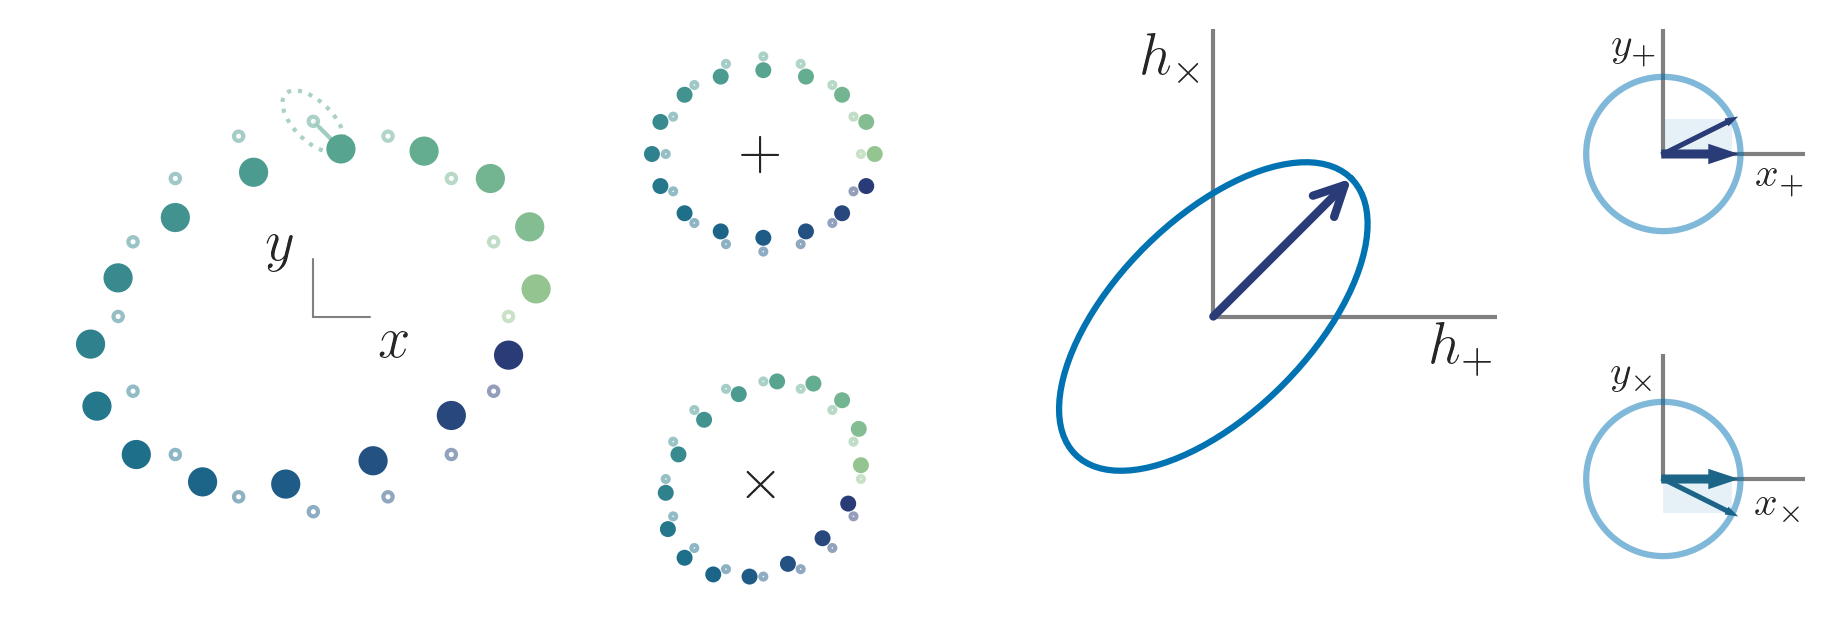

In [5]:
for wt in linspace(0, 2*pi, 1):
    plot_instant(wt, ellip=0.5, theta=pi/4);

We can use the same function above to produce animations of the polarization state. These are saved to disk (not displayed).

In [6]:
# get GIF
# see https://ndres.me/post/matplotlib-animated-gifs-easily/
def get_snap(*args, **kws):
    fig = plot_instant(*args, **kws);
    
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

### Circular polarizations

In [7]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
nfs = 50
figlist = []
for wt in linspace(0, 2*pi, nfs):
    figlist.append(get_snap(wt))
    plt.close()
imageio.mimsave('pol_circ_r.gif', figlist, fps=12);

In [12]:
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
nfs = 50
figlist = []
for wt in linspace(2*pi, 0, nfs):
    figlist.append(get_snap(wt))
    plt.close()
imageio.mimsave('pol_circ_l.gif', figlist, fps=12);

### Linear polarizations

In [13]:
nfs = 50
figlist = []
for wt in linspace(0, 2*pi, nfs):
    figlist.append(get_snap(wt, ellip=0))
    plt.close()
imageio.mimsave('pol_lin_p.gif', figlist, fps=12);

In [14]:
nfs = 50
figlist = []
for wt in linspace(0, 2*pi, nfs):
    figlist.append(get_snap(wt, ellip=0, theta=pi/2))
    plt.close()
imageio.mimsave('pol_lin_c.gif', figlist, fps=12);

In [15]:
nfs = 50
figlist = []
for wt in linspace(0, 2*pi, nfs):
    figlist.append(get_snap(wt, ellip=0, theta=pi/4))
    plt.close()
imageio.mimsave('pol_lin_diag.gif', figlist, fps=12);

In [16]:
nfs = 50
figlist = []
for wt in linspace(0, 2*pi, nfs):
    figlist.append(get_snap(wt, ellip=0.5, theta=pi/4))
    plt.close()
imageio.mimsave('pol_ellip.gif', figlist, fps=12);

## License

Copyright 2022 Maximiliano Isi max.isi@ligo.org

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301, USA.